<a href="https://colab.research.google.com/github/PavelStelmakhV/hw310-keras-fasion-mnist/blob/main/keras_fasion_mnist_hw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [306]:
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
from keras import layers
from keras import regularizers

In [307]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [308]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [309]:
train_images = train_images / 255.0

test_images = test_images / 255.0

In [310]:
model = tf.keras.Sequential()

model.add(layers.Flatten(input_shape=(28, 28)))
# model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dropout(0.3))
# model.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))

model.add(layers.Dense(10))
model.add(layers.Softmax())

In [311]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [312]:
# model.fit(train_images, train_labels, epochs=20)
history = model.fit(train_images,
                    train_labels,
                    epochs=40,
                    batch_size=512,
                    validation_data=(test_images, test_labels))
test_loss, test_acc = model.evaluate(test_images, test_labels)
print('\nTest accuracy:', test_acc)

Epoch 1/40
118/118 [==============================] - 4s 25ms/step - loss: 1.2306 - accuracy: 0.7413 - val_loss: 0.8735 - val_accuracy: 0.8236
Epoch 2/40
118/118 [==============================] - 3s 24ms/step - loss: 0.8026 - accuracy: 0.8339 - val_loss: 0.7235 - val_accuracy: 0.8463
Epoch 3/40
118/118 [==============================] - 3s 26ms/step - loss: 0.6780 - accuracy: 0.8494 - val_loss: 0.6344 - val_accuracy: 0.8510
Epoch 4/40
118/118 [==============================] - 4s 37ms/step - loss: 0.6006 - accuracy: 0.8571 - val_loss: 0.5787 - val_accuracy: 0.8565
Epoch 5/40
118/118 [==============================] - 3s 25ms/step - loss: 0.5581 - accuracy: 0.8605 - val_loss: 0.5372 - val_accuracy: 0.8621
Epoch 6/40
118/118 [==============================] - 3s 25ms/step - loss: 0.5256 - accuracy: 0.8625 - val_loss: 0.5187 - val_accuracy: 0.8647
Epoch 7/40
118/118 [==============================] - 3s 25ms/step - loss: 0.5014 - accuracy: 0.8665 - val_loss: 0.4948 - val_accuracy: 0.8635

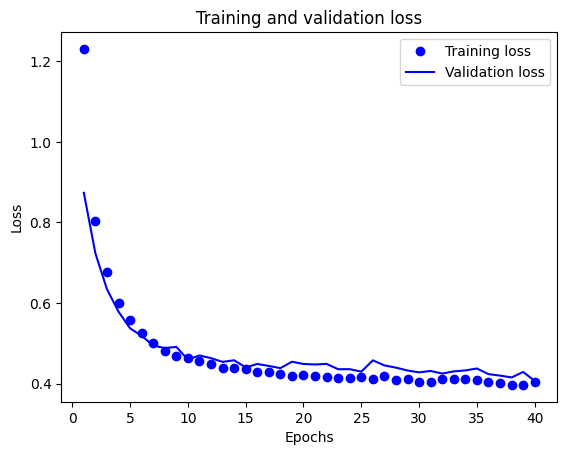

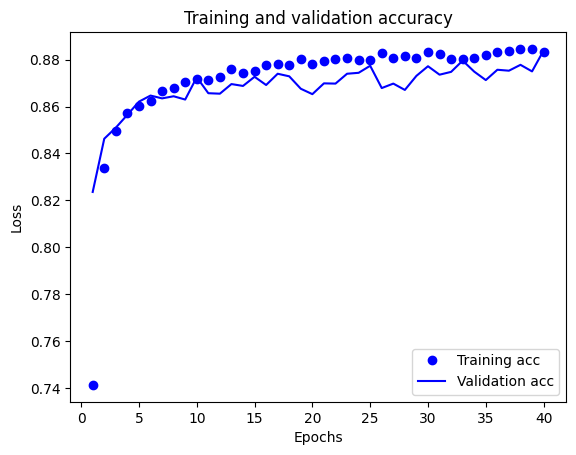

In [313]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(history_dict['accuracy']) + 1)

plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.clf()
val_acc_values = history_dict['val_accuracy']
plt.plot(epochs, history_dict['accuracy'], 'bo', label='Training acc')
plt.plot(epochs, history_dict['val_accuracy'], 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [314]:
probability_model = tf.keras.Sequential([model,
                                         tf.keras.layers.Softmax()])

In [315]:
predictions = probability_model.predict(test_images)

313/313 [==============================] - 1s 2ms/step


In [316]:
predictions[0]

array([0.08632683, 0.08631688, 0.08631483, 0.08631777, 0.0863112 ,
       0.09050774, 0.08633439, 0.08927628, 0.08633514, 0.21595895],
      dtype=float32)